# Propagation effects

In this notebook we will have a look at the individuel propagation effects that can be included.

## Setup

In [1]:
import numpy as np
from acoustics.signal import OctaveBand
from auraliser import Auraliser, mono
from auraliser.generator import Sine, Noise
from geometry import Point
from IPython.display import Audio
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9.0, 6.0)
%matplotlib inline
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
fs = 44100.0      # Sample frequency
duration = 15.      # Duration in seconds
df = 50.0           # Frequency resolution (impedances reflections)

dt = 1.0/fs                             # Seconds per sample
t = np.arange(0.0, duration, dt)        # Time vector

frequency = 1000.0

model = Auraliser(duration=duration, sample_frequency=fs)

We will need a source

In [3]:
speed = 100.0
x = np.ones_like(t) * speed * (t - duration/2.0)    # Source moves along the x-axis.
y = np.ones_like(t) * 0.01
z = np.ones_like(t) * 200.0   # Altitude of source
src = model.add_source(name='source', position=np.vstack((x,y,z)).T)
#src = model.add_source(name='source', position=Point(0.0,0.0,0.0))
subsrc = src.add_subsource(name='subsource')

emitting a sine wave and pink noise

In [4]:
sine = subsrc.add_virtualsource('sine', signal = Sine(frequency=frequency))
#noise = subsrc.add_virtualsource('pink', signal = Noise(color='pink'), level=140.)

and a receiver.

In [5]:
rcv = model.add_receiver(name='receiver', position=Point(0.0,0.0,4.0))

Because we would like to consider the propagation effects individually we turn them all of for now.

In [6]:
model.settings['spreading']['include'] = False
model.settings['doppler']['include'] = False
model.settings['atmospheric_absorption']['include'] = False
model.settings['reflections']['include'] = False
model.settings['turbulence']['include'] = False

## Effects

Now that we have a basic model to work with we look at the propagation effects one by one.

In [7]:
signal = mono( rcv.auralise() )

INFO:root:auralise: Auralising at receiver
INFO:root:auralise: Can auralise.
INFO:root:_auralise_source: Auralising source source
INFO:root:_auralise_subsource: Generating subsource emission signals.
INFO:root:_auralise_subsource: Determine mirrors.
INFO:root:_auralise_subsource: Not searching for mirror sources. Either reflections are disabled or there are no walls.
INFO:root:_apply_propagation_effects: Auralising mirror
INFO:root:_auralise_source: Finished auralising source source


In [8]:
Audio(data=signal, rate=fs)

### Distance reduction

In the far field sound spreads out spherically. This results in a decrease in amplitude with increase in distance.

In [9]:
model.settings['spreading']['include'] = True
signal = mono( rcv.auralise() )
model.settings['spreading']['include'] = False

INFO:root:auralise: Auralising at receiver
INFO:root:auralise: Can auralise.
INFO:root:_auralise_source: Auralising source source
INFO:root:_auralise_subsource: Generating subsource emission signals.
INFO:root:_auralise_subsource: Determine mirrors.
INFO:root:_auralise_subsource: Not searching for mirror sources. Either reflections are disabled or there are no walls.
INFO:root:_apply_propagation_effects: Auralising mirror
INFO:root:_apply_propagation_effects: Applying spherical spreading.
INFO:root:_auralise_source: Finished auralising source source


In [10]:
Audio(data=signal, rate=fs)

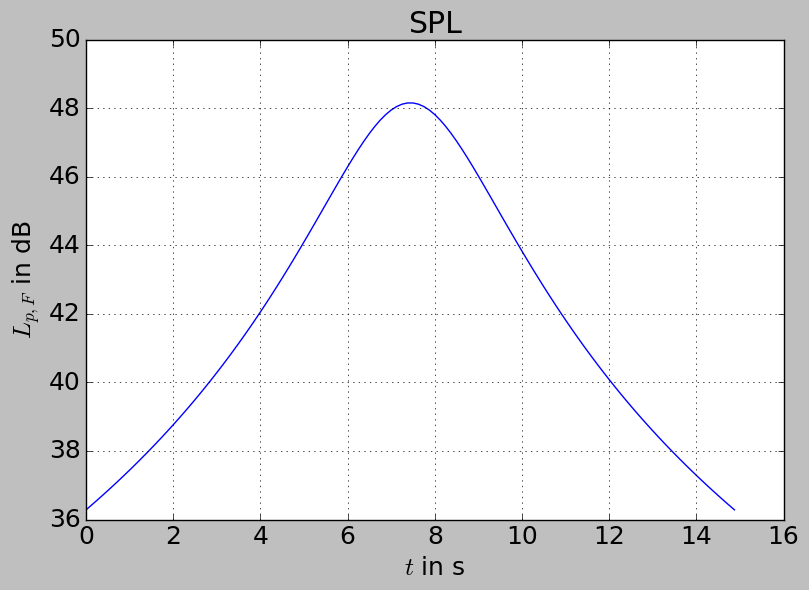

In [11]:
fig = signal.plot_levels()

### Time delay

Sound has a limited velocity resulting in a delay between emission and receivement. Movement of source and/or receiver can result in a variable time delay.

Besides the obvious time delay this also results in a Doppler shift in frequency.

In [12]:
model.settings['doppler']['include'] = True
signal = mono( rcv.auralise() )
model.settings['doppler']['include'] = False

INFO:root:auralise: Auralising at receiver
INFO:root:auralise: Can auralise.
INFO:root:_auralise_source: Auralising source source
INFO:root:_auralise_subsource: Generating subsource emission signals.
INFO:root:_auralise_subsource: Determine mirrors.
INFO:root:_auralise_subsource: Not searching for mirror sources. Either reflections are disabled or there are no walls.
INFO:root:_apply_propagation_effects: Auralising mirror
INFO:root:_apply_propagation_effects: Applying Doppler frequency shift.
INFO:root:_auralise_source: Finished auralising source source


In [13]:
Audio(data=signal, rate=fs)

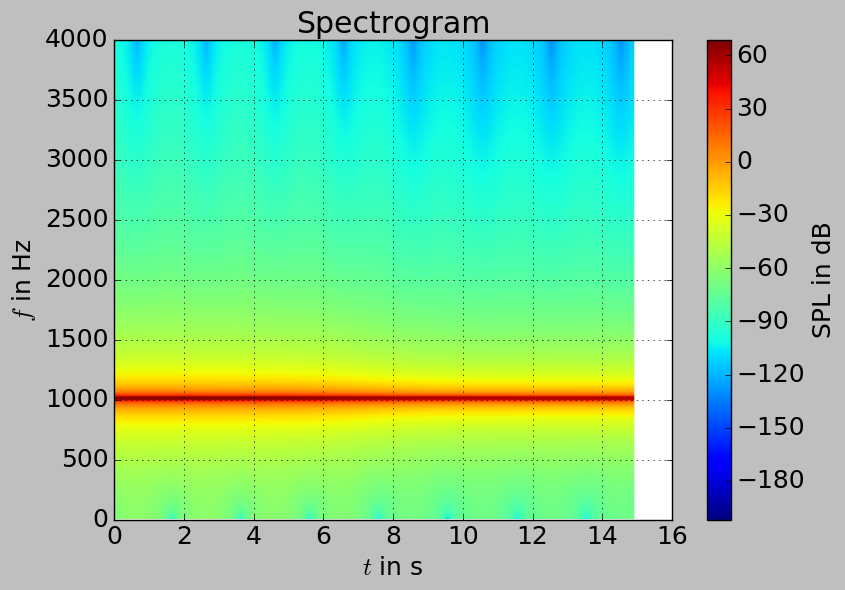

In [14]:
fig = signal.spectrogram(ylim=(0.0, 4000.0))

### Atmospheric absorption

Relaxation effects in the atmosphere result in additional attenuatation. 

In [15]:
model.settings['atmospheric_absorption']['include'] = True
signal = mono( rcv.auralise() )
model.settings['atmospheric_absorption']['include'] = False

INFO:root:auralise: Auralising at receiver
INFO:root:auralise: Can auralise.
INFO:root:_auralise_source: Auralising source source
INFO:root:_auralise_subsource: Generating subsource emission signals.
INFO:root:_auralise_subsource: Determine mirrors.
INFO:root:_auralise_subsource: Not searching for mirror sources. Either reflections are disabled or there are no walls.
INFO:root:_apply_propagation_effects: Auralising mirror
INFO:root:_apply_propagation_effects: Applying atmospheric absorption.
INFO:root:_auralise_source: Finished auralising source source


In [16]:
Audio(data=signal, rate=fs)

In [17]:
fig = signal.spectrogram(ylim=(0.0, 4000.0))

ValueError: Cannot plot spectrogram of multichannel signal. Please select a single channel.

In [ ]:
fig = signal.plot_levels()

### Atmospheric turbulence

In [ ]:
model.settings['turbulence']['include'] = True
signal = mono( rcv.auralise() )
model.settings['turbulence']['include'] = False

In [ ]:
Audio(data=signal, rate=fs)

In [ ]:
fig = signal.spectrogram(ylim=(0.0, 4000.0))

In [ ]:
_ = signal.plot_levels()

In [ ]:
signal.leq()

### Ground reflection

A ground reflection without a propagation delay 

In [ ]:
from ism import Wall
frequencies = np.arange(0.0, fs/2.0, df)
impedance = np.ones_like(frequencies) + 1j*np.ones_like(frequencies)

groundcorners1 = [Point(-100.0, -100.0, 0.0), 
                  Point(100.0, -100.0, 0.0), 
                  Point(100.0, 100.0, 0.0), 
                  Point(-100.0, 100.0, 0.0) ]
ground1 = Wall(groundcorners1, impedance, Point(0.0, 0.0, 0.0))

model.geometry.walls = [ground1]

In [ ]:
model.settings['reflections']['include'] = True
model.settings['reflections']['force_hard'] = True

signal = mono( rcv.auralise() )

model.settings['reflections']['include'] = False
model.settings['reflections']['force_hard'] = False

In [ ]:
Audio(data=signal, rate=fs)

In [ ]:
fig = signal.spectrogram(ylim=(0.0, 4000.0))

### All effects

Finally, we enable all propagation effects.

In [ ]:
Audio(data=signal, rate=fs)

In [ ]:
fig = signal.spectrogram(ylim=(0.0, 8000.0))

In [ ]:
_ = signal.plot_levels()

In [ ]:
f, o = signal.octaves()
_ = o.plot_levels(labels=f.nominal)